In [14]:
from keras.layers import Input, Dense
from keras.models import Model
from keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import scipy.stats as ss
from keras import regularizers
from keras.callbacks import ModelCheckpoint, TensorBoard
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA, KernelPCA

In [15]:
import seaborn as sns
sns.set(color_codes=True)
%matplotlib inline

In [16]:
RANDOM_SEED = 42

In [17]:
data_lda = pickle.load(file=open('./pickles/mallet_doc_corpus.pickle', 'rb'))
data_original = pd.read_csv('./pickles/data_pd.csv')

### Data Preprocessing

500 Input topics
Setting topic threshold at 0.1
Pruned to 405 topics
Zeroing any values below 0.01


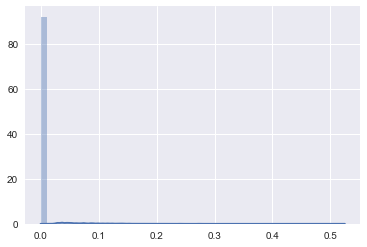

In [89]:
#Get Topics
topics = pickle.load(file=open('./pickles/mallet_learnt_topics.pickle','rb'))
topic_lst = [0]*len(topics)
i = 0
for topic in topics:
    topic_lst[i] = np.array(topic[1])[:, 0]
    i+=1
topics = topic_lst
print(len(topics), 'Input topics')

#Augment Vector if Required
data_in = data_lda[:]
data_agg = np.zeros(np.shape(data_in)[1])
threshold = 0.10
min_score = 1
threshold_prob = 0.01

#Set baseline threshold for entire corpus
print('Setting topic threshold at', threshold)
for paper in data_in:
    chk = paper[paper > threshold]
    data_agg = np.add(data_agg, (paper > threshold).astype(int))
prune = (data_agg >= min_score).astype(int) #Stuff to keep
idx_arr = np.arange(np.shape(data_in)[1])
idx_arr = idx_arr[prune == 0]

#Clean corresponding topics
for i in reversed(idx_arr):
    del(topics[i])
    
data_in = data_in[:, prune == 1]
print('Pruned to', len(topics), 'topics')

#Remove near-zero values
data_in[data_in < threshold_prob] = 0
print('Zeroing any values below', threshold_prob)

#Sum to 1?
sum_one = np.sum(data_in, axis = 1)
sum_one[sum_one == 0] = 1 #Resolve any 0 errors

data_in = data_in/sum_one[:,None]

# data_in = StandardScaler().fit_transform(data_in)
# print('Normalised to zero-mean and unit variance')
# OR
# data_in = np.subtract(data_in, np.min(data_in, axis = 0))/(np.max(data_in, axis = 0) - np.min(data_in, axis = 0))
# print('Max-min normalised')
sns.distplot(data_in[:, 5])
#data_in = np.subtract(data_in, np.mean(data_in, axis = 0))/np.var(data_in, axis = 0)

In [19]:
pickle.dump(file=open('./pickles/mallet_pruned.pickle', 'wb'), obj = data_in)

In [82]:
num_components = 500

### K-Means on Papers

In [61]:
from sklearn.cluster import KMeans

In [76]:
k_m = KMeans(n_clusters=num_components, max_iter = 1000)
k_m.fit(data_in)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=1000,
    n_clusters=500, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [77]:
centers = k_m.cluster_centers_
assignments = k_m.labels_

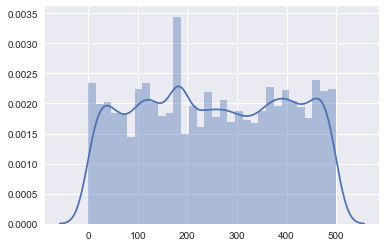

In [78]:
sns.distplot(assignments)

In [81]:
# for idx, k in enumerate(assignments):
#     if k == 386:
#         print(data_original.iloc[idx, :]['title'])

### Expectation-Maximisation on Papers

In [83]:
from sklearn.mixture import GaussianMixture

In [88]:
e_m = GaussianMixture(n_components = 100, max_iter = 100, verbose = 2)
e_m.fit(data_in)

### X-Means

In [20]:
from pyclustering.cluster.xmeans import xmeans, splitting_type

In [40]:
data_norm = StandardScaler().fit_transform(data_in)

In [41]:
dataset = [tuple(item) for item in data_norm]
print(len(dataset[0]))

405


In [42]:
xmeans_instance = xmeans(dataset, criterion= splitting_type.MINIMUM_NOISELESS_DESCRIPTION_LENGTH, tolerance = 0.00001, kmax = 100, ccore = False);
xmeans_instance.process()
clusters = xmeans_instance.get_clusters();
centers = xmeans_instance.get_centers();

In [39]:
print(np.shape(clusters))

(1, 34294)


### Autoencoder (does not work)

In [83]:
x_train, x_test, y_train, y_test = train_test_split(data_in[:], data_in[:], test_size=0.1, random_state=RANDOM_SEED, shuffle=True)

In [84]:
encoding_dim = 405
input_dim = np.shape(data_in)[1]

In [85]:
#Encoder
input_data = Input(shape=(input_dim,))
encoded = Dense(800, activation='tanh')(input_data)
encoded = Dense(500, activation='tanh')(encoded)
encoded = Dense(encoding_dim, activation='tanh')(encoded)

#Decoder
decoded = Dense(800, activation='tanh')(encoded)
decoded = Dense(input_dim, activation='tanh')(decoded)

autoencoder = Model(input_data, decoded)

In [86]:
autoencoder.compile(optimizer=Adam(lr=0.001), loss='mse')
checkpointer = ModelCheckpoint(filepath="model.h5",
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)
history = autoencoder.fit(x_train, x_train, epochs=8, batch_size=50, shuffle=True, verbose = 1, callbacks=[checkpointer, tensorboard], validation_data=(x_test, x_test)).history, 

Train on 30864 samples, validate on 3430 samples
Epoch 1/8
30864/30864 [==============================] - 10s - loss: 7.2489e-05 - val_loss: 1.7730e-05
Epoch 2/8
30864/30864 [==============================] - 9s - loss: 1.4671e-05 - val_loss: 1.3673e-05
Epoch 3/8
30864/30864 [==============================] - 13s - loss: 1.3840e-05 - val_loss: 1.2016e-05
Epoch 4/8
30864/30864 [==============================] - 14s - loss: 1.3713e-05 - val_loss: 1.4796e-05
Epoch 5/8
30864/30864 [==============================] - 11s - loss: 1.6116e-05 - val_loss: 1.7202e-05
Epoch 6/8
30864/30864 [==============================] - 10s - loss: 1.3844e-05 - val_loss: 1.5720e-05
Epoch 7/8
30864/30864 [==============================] - 10s - loss: 1.4586e-05 - val_loss: 1.9963e-05
Epoch 8/8
30864/30864 [==============================] - 11s - loss: 1.4947e-05 - val_loss: 1.2272e-05


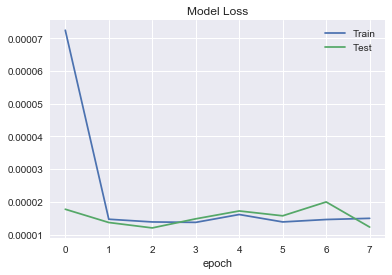

In [87]:
plt.plot(history[0]['loss'])
plt.plot(history[0]['val_loss'])
plt.title('Model Loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'], loc='upper right');
plt.show()
reconstruct[reconstruct < 0.01] = 0
i = 68
print(np.sum(x_test[i] - reconstruct[i]))
print(x_test[i] - reconstruct[i])